## Whale Detection Trainer with YOLO11

**This notebook is adapted from  Evan Juras, [EJ Technology Consultants](https://ejtech.io)**

**Author:** Diana Sulyma

**Last Updated:** October 27, 2025

**GitHub:** [Whale Detection from Video Footage with YOLO11](https://github.com/dianasulyma/Killer-Whale-Detection-from-Aerial-Footage) 

This notebook is the main data-processing and model trainer notebook for whale detection with YOLO11 task. 

In this notebook, we do the following: 
1. Upload annoted whale images. 
2. Perform 'train-validation' split. 
3. Configure the training job with correct input and output files. 
4. Train the model. 
5. Test the model.
6. Save the model to local machine.    

### Importing Libraries

In [13]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cv2
from ultralytics import YOLO
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import yaml
import glob
from IPython.display import Image, display

### Verify NVIDIA GPU Availability

In [3]:
!nvidia-smi

Mon Oct 27 12:56:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Import Data

In [4]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

!cp /content/gdrive/MyDrive/path/to/data.zip /content

Mounted at /content/drive
cp: cannot stat '/content/gdrive/MyDrive/path/to/data.zip': No such file or directory


In [5]:
# unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

### Train-Validation Split

In [6]:
# split train and validation images
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.7

--2025-10-27 12:56:42--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-10-27 12:56:42 (41.8 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 85
Number of annotation files: 85
Images moving to train: 59
Images moving to validation: 26


### Configure Training

In [9]:
'''
Python function to automatically create data.yaml config file
1. Reads "classes.txt" file to get list of class names
2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
3. Writes data in YAML format to data.yaml
'''

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 1
names:
- killer_whale


### Model Training

In [10]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

### Model Testing

In [11]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/26 /content/data/validation/images/02245595-pic_928.jpg: 448x640 1 killer_whale, 89.5ms
image 2/26 /content/data/validation/images/04f729da-pic_719_Male.jpg: 640x640 1 killer_whale, 17.0ms
image 3/26 /content/data/validation/images/162a21b8-pic_755_Male.jpg: 640x640 1 killer_whale, 16.9ms
image 4/26 /content/data/validation/images/18e2539c-pic_933.jpg: 256x640 1 killer_whale, 91.0ms
image 5/26 /content/data/validation/images/1c999b5d-pic_939.jpg: 640x576 1 killer_whale, 84.3ms
image 6/26 /content/data/validation/images/1ccdde41-pic_944.jpg: 576x640 1 killer_whale, 85.9ms
image 7/26 /content/data/validation/images/30d79272-pic_935.jpg: 640x544 1 killer_whale, 84.0ms
image 8/26 /content/data/validation/images/4351ef43-pic_89_Male.jpg: 384x640 1 killer_whale, 82.7ms
image 9/26 /content/data/validation/images/4acfeae

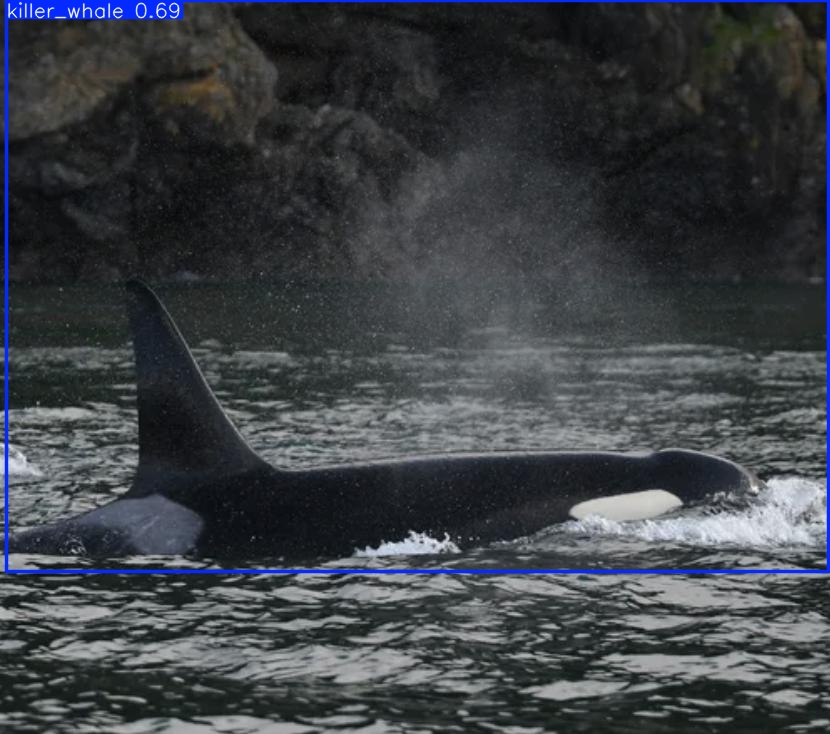

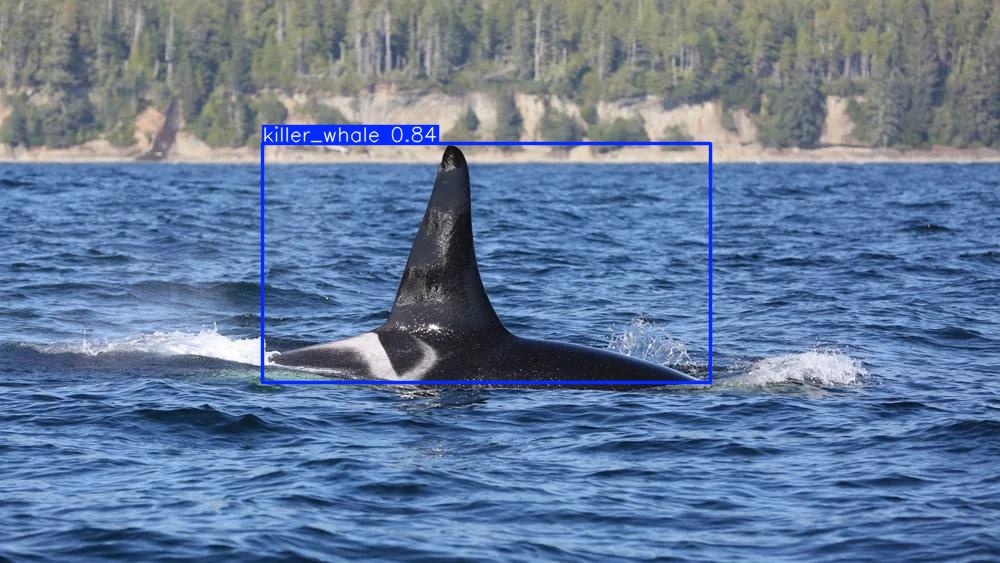

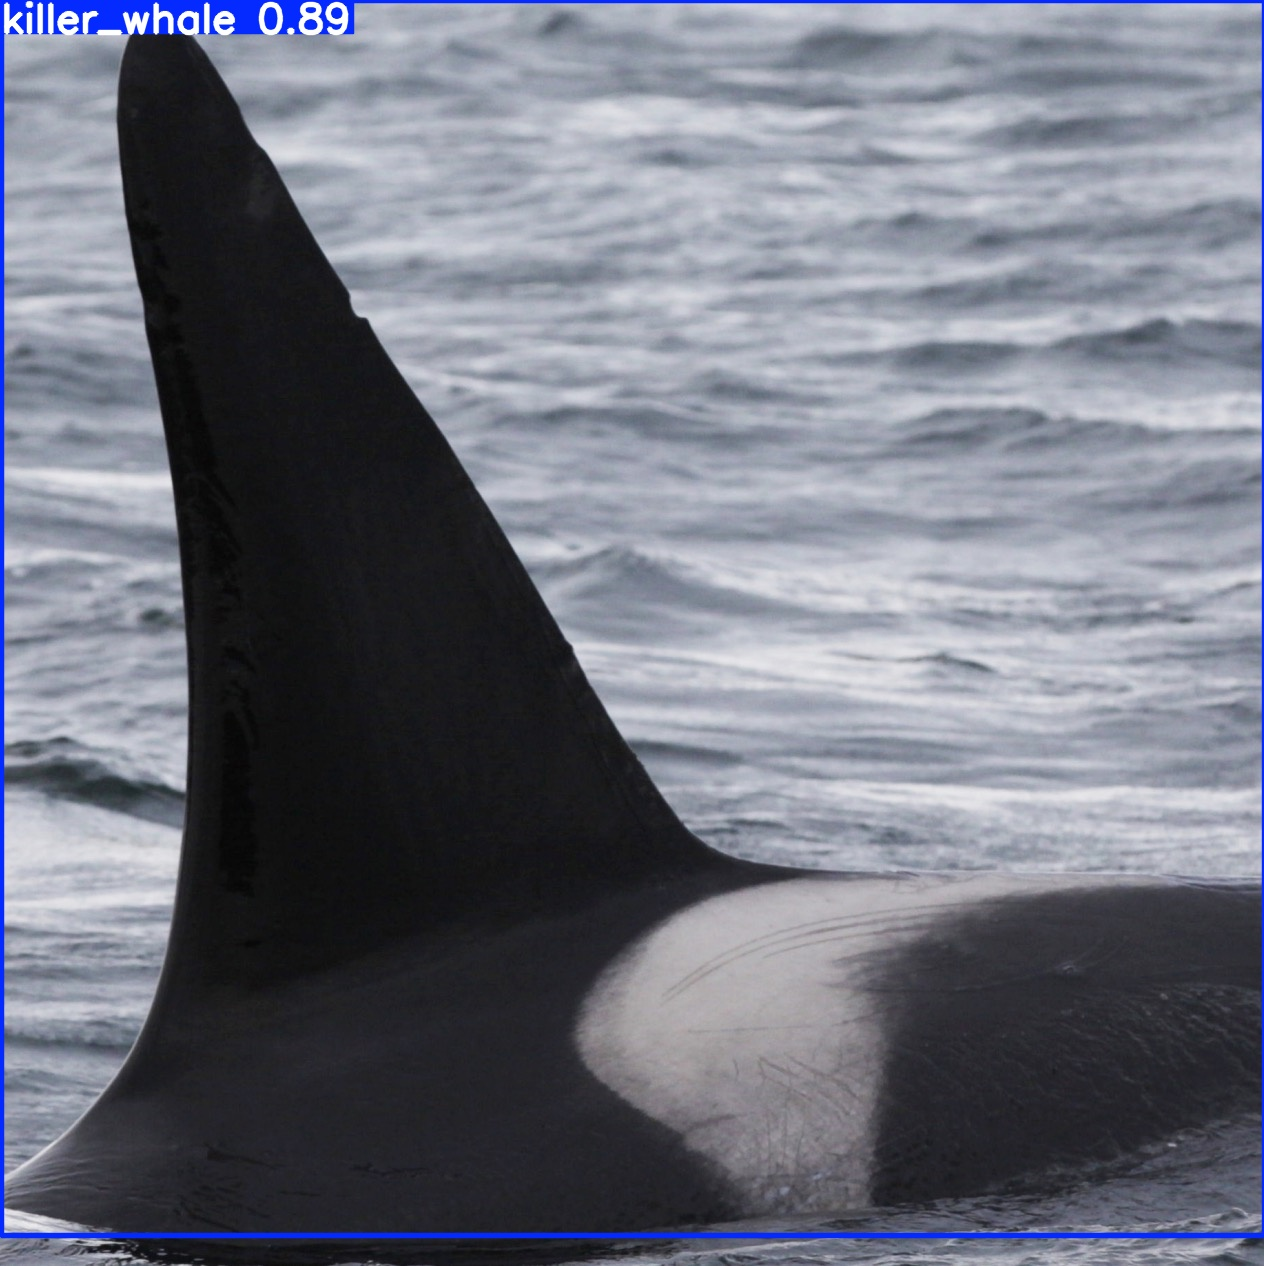

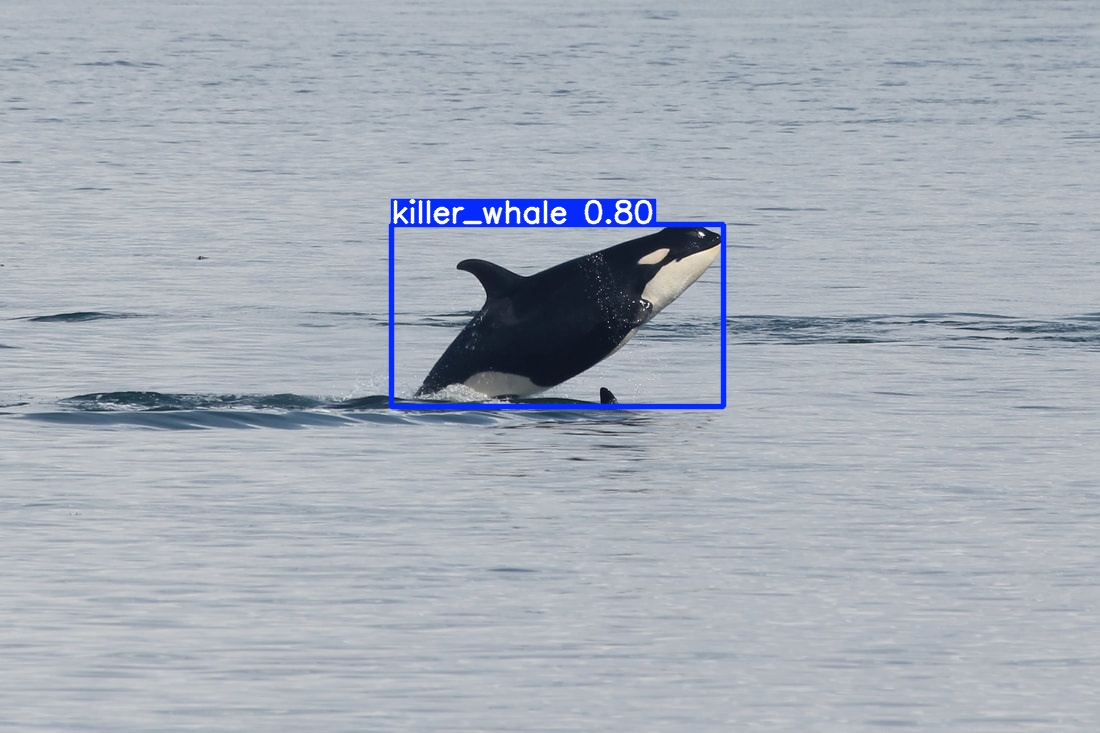

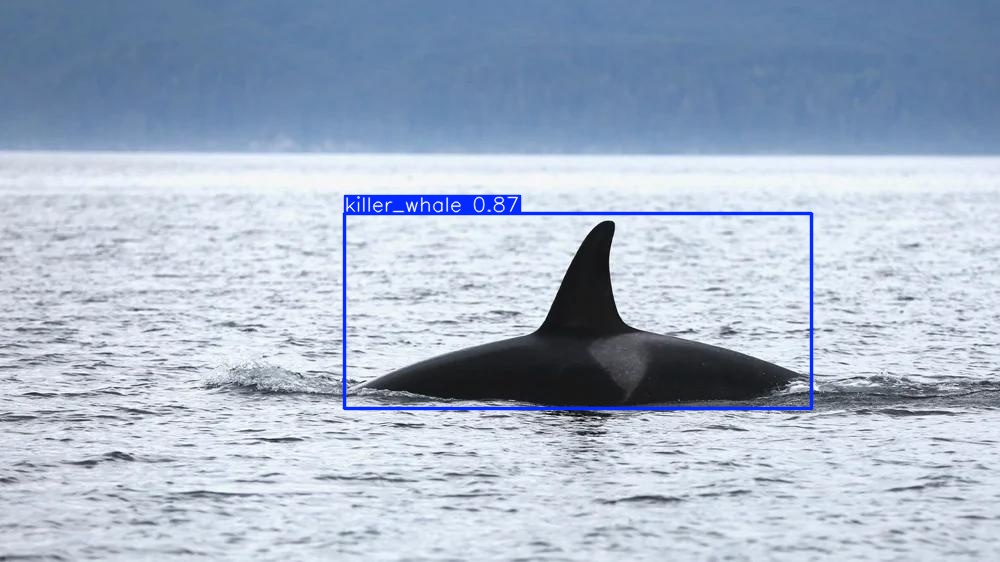

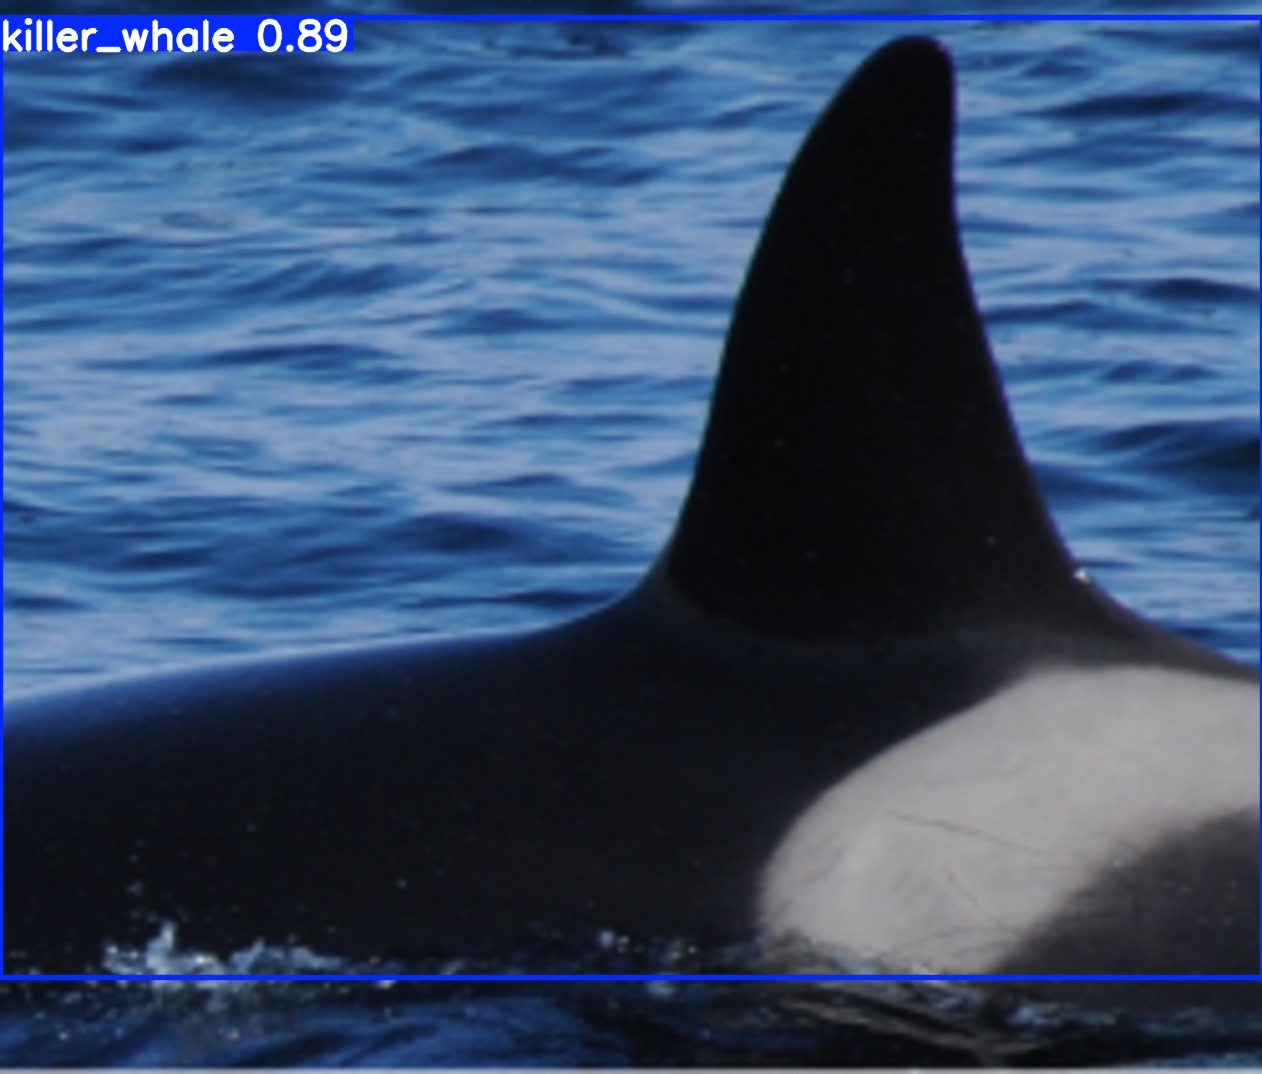

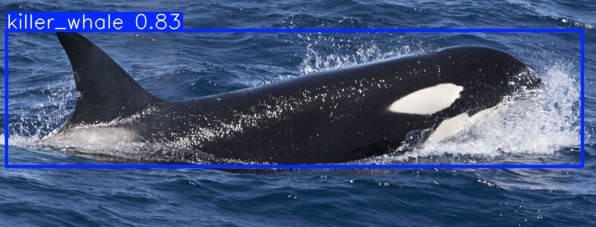

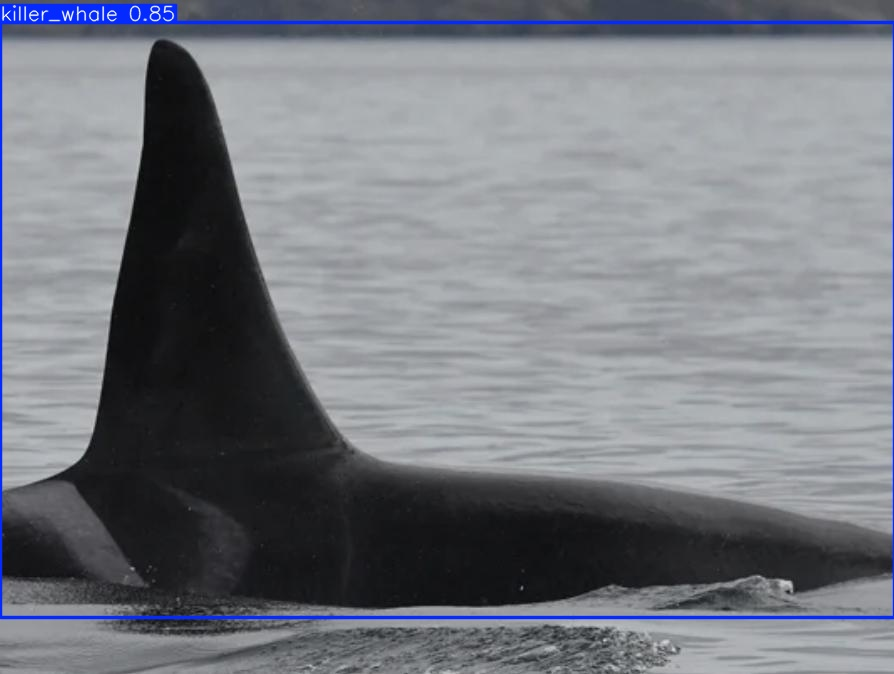

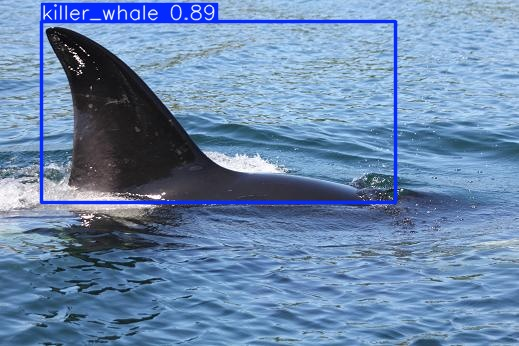

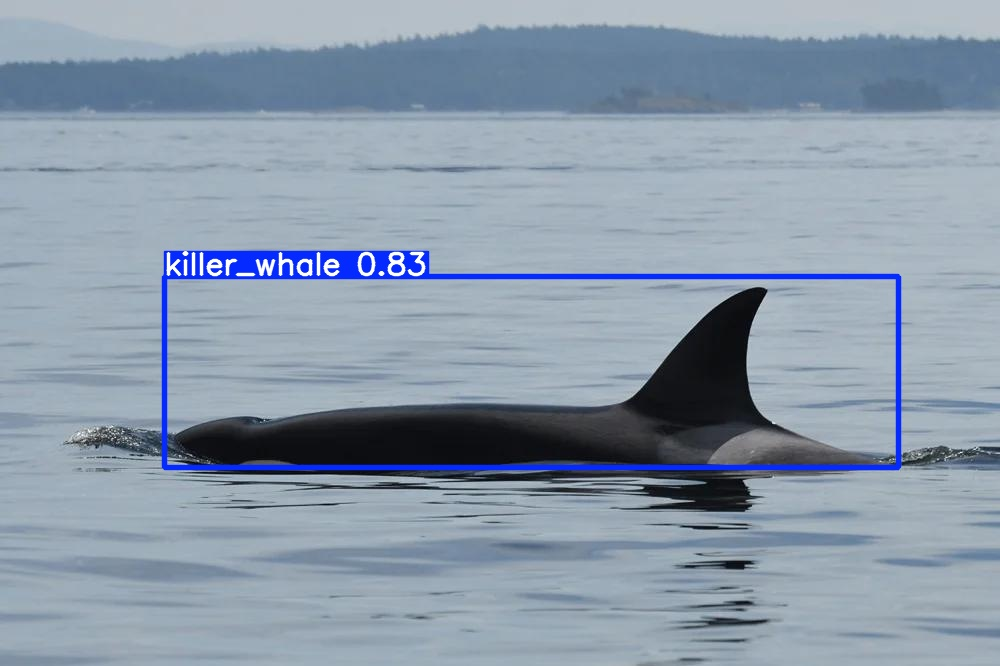

In [14]:
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')

### Download the Model

In [15]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/val_batch0_labels.jpg (deflated 13%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/BoxPR_curve.png (deflated 28%)
  adding: train/train_batch200.jpg (deflated 8%)
  adding: train/val_batch0_pred.jpg (deflated 13%)
  adding: train/results.png (deflated 6%)
  adding: train/train_batch202.jpg (deflated 13%)
  adding: train/labels.jpg (deflated 54%)
  adding: train/BoxP_curve.png (deflated 19%)
  adding: train/results.csv (deflated 59%)
  adding: train/train_batch0.jpg (deflated 4%)
  adding: train/BoxF1_curve.png (deflated 16%)
  adding: train/BoxR_curve.png (deflated 18%)
  adding: train/train_batch1.jpg (deflated 5%)
  adding: train/train_batch2.jpg (deflated 5%)
  adding: train/confusion_matrix.png (deflated 38%)
  adding: train/args.yaml (deflated 53%)
  adding: train/confusion_matrix_norma

In [16]:
# download the model
from google.colab import files

files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>